# Mask R-CNN for DeepScore

For our own dataset DeepScore

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config


%matplotlib inline 

C:\Users\johnl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import datetime
import numpy as np

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# for mask
import pathlib
from skimage.io import imread, imsave, imshow
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patchess

import skimage

# process xml file
import xml.etree.ElementTree

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Configurations

In [3]:
class ScoreConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "symbols"

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"
    
    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_MIN_SCALE = 2.0
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (28, 28)  # (height, width) of the mini-mask
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000
    
    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 1000/IMAGES_PER_GPU
    VALIDATION_STEPS = 50/IMAGES_PER_GPU

    # Number of classes (including background)
    NUM_CLASSES = 1 + 114  # background + 114 symbols

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 512

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 512

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 512

    
config = ScoreConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                127
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               512
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [33]:
class ScoreDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_score(self, dataset_dir, subset, split):
        """Load a subset of the DeepScore dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
    
        for key, value in class_dict.items():
            self.add_class("symbol", value, key)
        # Train or validation dataset? 
        assert subset in ["train", "val"]
        img_dir = pathlib.Path(dataset_dir).glob('*/images_png_small/*.png')       
        img_sorted = sorted([x for x in img_dir])
        xml_dir = pathlib.Path(dataset_dir).glob('*/xml_annotations_small/*.xml')       
        xml_sorted = sorted([x for x in xml_dir])
        mask_dir = pathlib.Path(dataset_dir).glob('*/pix_annotations_png_small/*.png')
        mask_sorted = sorted([x for x in mask_dir])
        if subset == "train":
            img_sorted = img_sorted[:split]
            xml_sorted = xml_sorted[:split]
            mask_sorted = mask_sorted[:split]
        if subset == "val":
            img_sorted = img_sorted[split:]
            xml_sorted = xml_sorted[split:]
            mask_sorted = mask_sorted[split:]
        
        # add images
        for i, image_path in enumerate(img_sorted):
#             image = imread(str(image_path))
#             height, width = image.shape[:2]
            image_name = os.path.basename(image_path)
            xml_path = xml_sorted[i]
            symbols, _, height, width = get_symbol_info(xml_path)
            
            mask_path = str(mask_sorted[i])
            # only select scores with less than 500 symbols
#             if len(symbols) < 200:
            self.add_image(
                "symbol",
                image_id=image_name,
                path=image_path,
                width=width, height=height,
                symbols=symbols, mask_path=mask_path)


    def image_reference(self, image_id):
        """Return the score data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "symbol":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
    
    def load_box(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "symbol":
            return super(self.__class__, self).load_mask(image_id)
        symbols = image_info['symbols']
        boxes = np.zeros([len(symbols), 4], dtype=np.int32)
        for i, symbol in enumerate(symbols):
            # coords are row, col, so we should put (y, x), instead of (x, y)
            xmin, xmax, ymin, ymax = symbol[1], symbol[2], symbol[3], symbol[4]
            boxes[i] = np.array([ymin, xmin, ymax, xmax])
        return boxes.astype(np.int32)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """        
        image_info = self.image_info[image_id]
        if image_info["source"] != "symbol":
            return super(self.__class__, self).load_mask(image_id)

        # image_id == xml_id
        symbols = image_info['symbols']
        mask = imread(image_info['mask_path'])
        masks = np.zeros([image_info['height'], image_info['width'], len(symbols)], dtype=np.uint8)
        for i, symbol in enumerate(symbols):
            # coords are row, col, so we should put (y, x), instead of (x, y)
            xmin, xmax, ymin, ymax = symbol[1], symbol[2], symbol[3], symbol[4]
            masks[ymin:ymax+1, xmin:xmax+1, i] = mask[ymin:ymax+1, xmin:xmax+1]
        
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in symbols])
            
        
        return masks.astype(np.bool), class_ids.astype(np.int32)

In [34]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = ScoreDataset()
    dataset_train.load_score(dataset_dir, "train", split)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = ScoreDataset()
    dataset_val.load_score(dataset_dir, "val", split)
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

## Load Data

In [36]:
# Glob the training data and load a single image path
img_paths = pathlib.Path('../../').glob('*/images_png_small/*.png')
img_sorted = sorted([x for x in img_paths])

# mask and xml files
mask_paths = pathlib.Path('../../').glob('*/pix_annotations_png_small/*.png')
mask_sorted = sorted([x for x in mask_paths])

xml_paths = pathlib.Path('../../').glob('*/xml_annotations_small/*.xml')
xml_sorted = sorted([x for x in xml_paths])

# check the image, mask and xml path names are in the same order
rand_img = 1
im_path = img_sorted[rand_img]
mask_path = mask_sorted[rand_img]
xml_path = xml_sorted[rand_img]
num_samples = len(img_sorted)
print(im_path)
print(len(img_sorted))
print(mask_path)
print(xml_path)
im = imread(str(im_path))
mask = imread(str(mask_path))
root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
size = root.findall('size')
width = float(size[0][0].text)
height = float(size[0][1].text)

..\..\Mask_RCNN\images_png_small\lg-46690-aug-gutenberg1939-.png
2
..\..\Mask_RCNN\pix_annotations_png_small\lg-46690-aug-gutenberg1939-.png
..\..\Mask_RCNN\xml_annotations_small\lg-46690-aug-gutenberg1939-.xml


In [21]:
# get the information of all symbols in one image
def get_symbol_info(xml_path):
    root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
    size = root.findall('size')
    width = float(size[0][0].text)
    height = float(size[0][1].text)

    symbols = []
    symbol_names = set() # use a set to store unique symbol names
    rectangles = []

    # get the bounding box for each object, multiply with its width and height to get the real pixel coords
    for symbol in root.findall('object'):
        name = symbol.find('name').text
        xmin = round(float(symbol.find('bndbox')[0].text)*width)
        xmax = round(float(symbol.find('bndbox')[1].text)*width)
        ymin = round(float(symbol.find('bndbox')[2].text)*height)
        ymax = round(float(symbol.find('bndbox')[3].text)*height)

#         current_rectangle = name, (xmin, ymin), xmax - xmin, ymax - ymin
        current_symbol = name, xmin, xmax, ymin, ymax
#         rectangles.append(current_rectangle)
        symbols.append(current_symbol)
        symbol_names.add(name)
    return symbols, symbol_names, int(height), int(width)

In [22]:
# uncomment the whole cell if you want to regenerate symbol set
# class_dict = {}
# symbol_type = set()
# # form a universal symbol set fot the whole dataset, this can take 2 ~ 3 min
# for x in xml_sorted:
#     _, symbol_names,_ = get_symbol_info(x)
#     symbol_type = symbol_type.union(symbol_names)

# # save the symbol_type set for convenience# save t 
# np.save('symbol_type.npy', symbol_type) 
# # Load the dictionary
# symbol_type = np.load('symbol_type.npy').item()
# print('Total num of symbols in the dictionary: %d' % (len(symbol_type)))
# i = 0
# for item in symbol_type:
#     class_dict[item] = i
#     i += 1
# print(class_dict['fClef'])
# # save the class dictionary for futre use so that the integer class label does not change every time
# np.save('class_dict.npy', class_dict)

In [23]:
# uncomment this cell if you want to load previous symbol dict
class_dict = np.load('class_dict.npy').item()
print('Total number of symbols in the whole dataset:', len(class_dict))
print('The integer value for fClef is:', class_dict['fClef'])

Total number of symbols in the whole dataset: 114
The integer value for fClef is: 85


# Create Dataset

In [48]:
# load dataset
# the directory where deepscore folder is in
dataset_dir = '../../'
# The former split number of data used as training data
# The latter num_samples - split number of data used as validation data
split = 2

In [49]:
# the dataset is very large, can take 1~3 minutes
# Training dataset
dataset_train = ScoreDataset()
dataset_train.load_score(dataset_dir, "train", split)
dataset_train.prepare()

# Validation dataset
dataset_val = ScoreDataset()
dataset_val.load_score(dataset_dir, "val", split)
dataset_val.prepare()

In [50]:
print("Image Count in training set: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
# for i, info in enumerate(dataset_train.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

Image Count in training set: 2
Class Count: 115


In [51]:
print("Image Count in validation set: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
# for i, info in enumerate(dataset_val.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

Image Count in validation set: 0
Class Count: 115


### Anchors

In [52]:
class RandomCropConfig(ScoreConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

Count:  16368
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48
Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


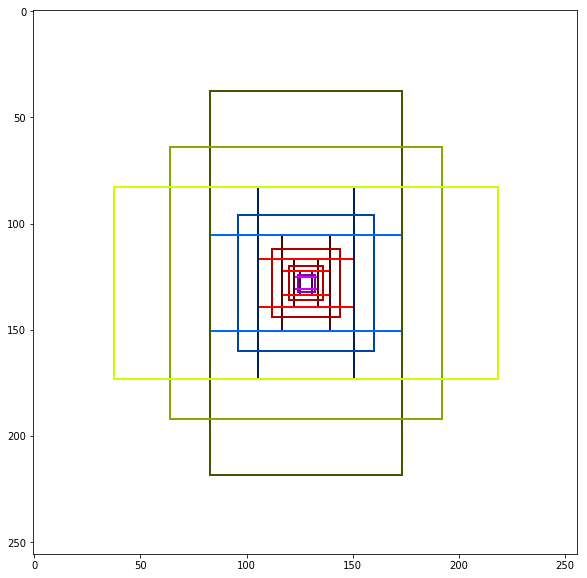

In [53]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_train, crop_config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [54]:
# Create data generator
random_rois = 50
g = modellib.data_generator(
    dataset_train, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=1,
    detection_targets=True)

In [55]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset_train.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

KeyboardInterrupt: 

anchors                  shape: (16368, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (3, 4)                min:  130.00000  max:  256.00000  float32
Positive anchors: 3
Negative anchors: 253
Neutral anchors: 16112
BG                     : 504
accidentalNatural      : 5
noteheadBlack          : 3


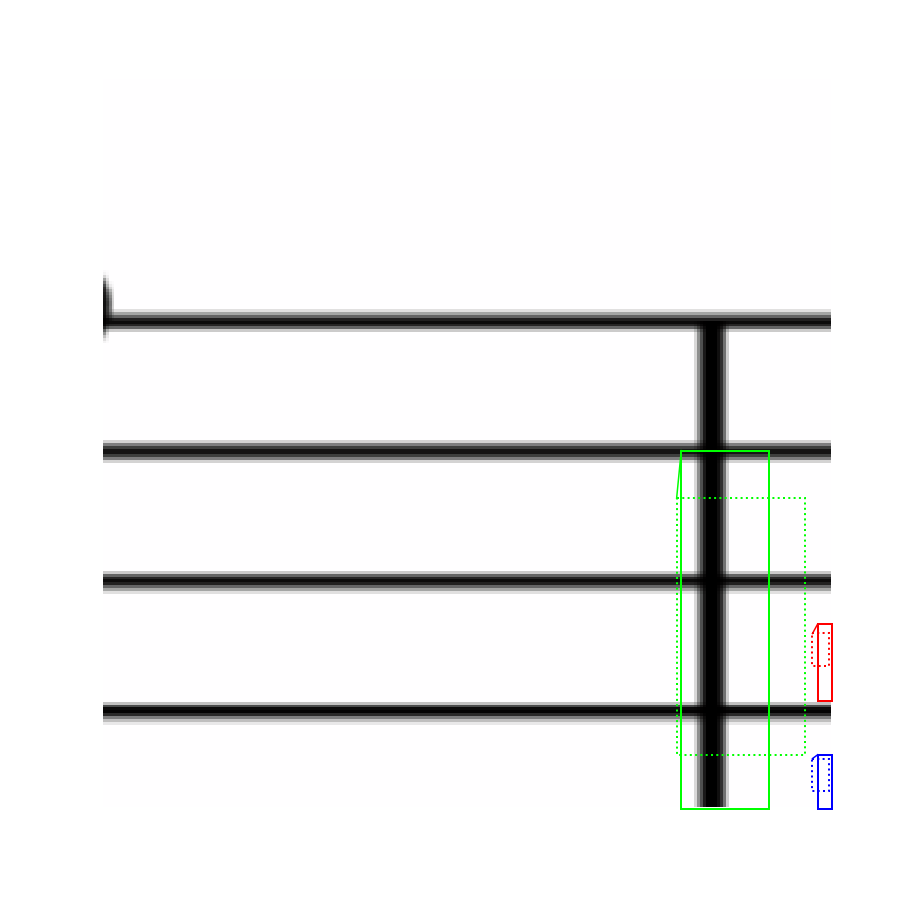

In [47]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset_train.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

## Ceate Model

In [26]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [27]:
# initialize weights from pretrained model instead of from scratch
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [33]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/Patty/Documents/stanford/courses/cs231n/project/fp/coop/Mask_RCNN/logs/symbols20180602T2251/mask_rcnn_symbols_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))